## SIR models
In this Jupyter Notebook, we will explore SIR models for infectious diseases and compare numerical simulations of these models to COVID-19 data published by the New York Times. Our model is given by
$$
\begin{align}
\frac{dS}{dt} & = -R_0SI \\
\frac{dI}{dt} & = R_0SI - I
\end{align}
$$
where $S$ and $I$ are the fractions of the susceptible and infected cohorts of the total population. This model assumes that individuals who recovered from the disease are immune and cannot be reinfected. The model is normalized so that $t=1$ corresponds to the average residence time of the diseases in an individual. The quantity $R_0$ is the basic reproduction number defined to be the average number of suceptible individuals that an infected individual will infect whilst being ill. First, we load the necessary Python modules.

In [1]:
%matplotlib widget
from math import *
from matplotlib.backend_bases import MouseButton
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

The next cell defines the right-hand side of our SIR model. In the model, x is the fraction of susceptible individuals in the total population, and y is the fraction of infected/infectious individuals. The parameter R<sub>0</sub> is the reproduction number, and time t is normalized so that unit time corresponds to the average residence time of the disease.

In [2]:
def f(x, y, R0): 
    return [-R0*x*y, R0*x*y-y]

The following function will allow us to generate direction fields and solutions of our SIR model.

In [3]:
def generate_phase_portrait(f, R0, xrange, yrange, tmax):
    def rhs(t, x): return f(x[0], x[1], R0)

    def plotdf(rhs, R0, xrange, yrange, grid, ax):
        x = np.linspace(max(xrange[0],0), xrange[1], grid[0])
        y = np.linspace(max(yrange[0],0.01), yrange[1], grid[1])
        X, Y = np.meshgrid(x, y)
        DX, DY = rhs(X, Y, R0)
        M = (np.hypot(DX, DY))
        M[M==0] = 1.0
        DX = DX/M
        DY = DY/M
        ax.quiver(X, Y, DX, DY, color='tab:green', angles='xy', alpha=0.5)

    def solve_ode(x):
        solf = solve_ivp(rhs, [0, tmax], x, t_eval=np.linspace(0, tmax, 1000), 
                         events=[cross_top, cross_bot, cross_lef, cross_rig],
                         atol=1.e-8, rtol=1.e-6)
        ax[0].scatter(x[0], x[1], color='tab:olive')
        ax[0].plot(solf.y[0], solf.y[1], color='tab:blue')
        ax[1].plot(solf.t, solf.y[0], color='tab:green', label='susceptibles')
        ax[1].plot(solf.t, solf.y[1], color='tab:red', label='infected')
        ax[1].plot(solf.t, 1-solf.y[0]-solf.y[1], color='tab:brown', label='recovered')
        
    def cross_top(t, x): return yrange[1]+0.5 - x[1]
    def cross_bot(t, x): return yrange[0]-0.5 - x[1]
    def cross_lef(t, x): return xrange[0]-0.5 - x[0]
    def cross_rig(t, x): return xrange[1]+0.5 - x[0]

    cross_top.terminal = True
    cross_bot.terminal = True
    cross_lef.terminal = True
    cross_rig.terminal = True
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].set_title("phase portrait")
    ax[0].set_xlabel('fraction of susceptibles in population')
    ax[0].set_ylabel('fraction of infected in population')
    ax[0].set_xlim(xrange)
    ax[0].set_ylim(yrange)
    ax[0].grid(True)
    ax[0].axhline(y=0, c='tab:green', linewidth=2)
    ax[0].axvline(x=0, c='tab:gray', linewidth=1)
    ax[0].scatter(1, 0, c='tab:green', s=60, marker='o')
    plotdf(f, R0, xrange, yrange, [11, 11], ax[0])
    
    ax[1].set_title("solution graphs")
    ax[1].set_xlabel('normalized time τ (τ=1 is mean residence time)')
    ax[1].set_ylabel('population fractions')
    ax[1].set_xlim([0, tmax])
    ax[1].set_ylim([0, 1])
    ax[1].grid(True)
    solve_ode([0.99, 0.01])
    ax[1].legend()
    plt.tight_layout()
    plt.show()
        
    def on_click(event):
        if event.button is MouseButton.LEFT:
            if event.inaxes == ax[0]:
                x = event.xdata
                y = event.ydata
                if x>xrange[0] and x<xrange[1] and y>yrange[0] and y<yrange[1]:
                    for c in ax[1].get_lines():
                        c.remove()
                    solve_ode([x, y])
            fig.canvas.draw()

    plt.connect('button_press_event', on_click)

The code will create a direction field with arrows indicating the slope of the tangents of solution curves. If you position your mouse anywhere in the left panel and click, the code will compute and plot the solution that starts at the location (x,y) of your mouse.

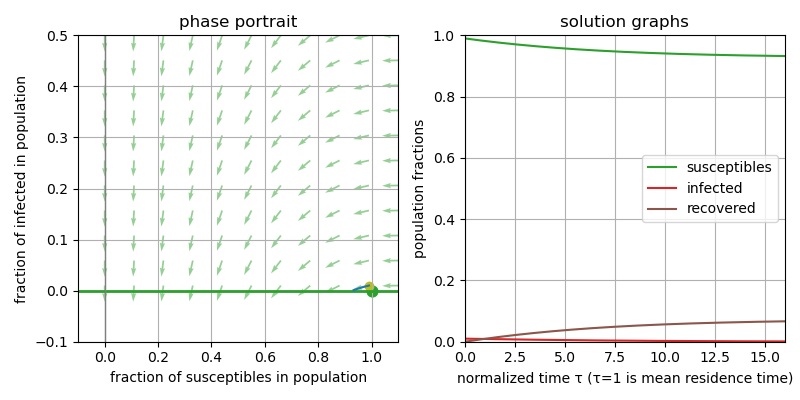

In [4]:
generate_phase_portrait(f, R0=0.9, xrange=[-0.1, 1.1], yrange=[-0.1, 0.5], tmax=16)

The following code visualizes the incidence dynamics and compares it with COVID-19 data.

In [5]:
def incidence_dynamics(f, N, T, R0range, yrange, tmax):
    def fivp(t, x, par): return f(x[0], x[1], par)

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].set_title("Incidence dynamics")
    ax[0].set_xlabel('time t [days]')
    ax[0].set_ylabel('number of new cases per day')
    ax[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax[0].set_xlim([0, tmax])
    ax[0].grid(True)

    ax[1].set_title("Total number of confirmed cases at time t [days]")
    ax[1].set_xlabel('time t [days]')
    ax[1].set_ylabel('log_10(I(t)+R(t))')
    ax[1].set_xlim([0, tmax])
    ax[1].grid(True)

    url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv'
    df = pd.read_csv(url, error_bad_lines=False)
    
    columns = ['cases', 'deaths']
    df = df[columns]
    covid_us = df.to_numpy()
    covid_us = covid_us[43:, :]
    index = np.arange(np.shape(covid_us)[0]) + 1

    ax[1].scatter(index, np.log10(covid_us[:,0]), label='US COVID')
    slope_data = np.polyfit(index[0:20], np.log(covid_us[0:20,0]), 1)*T + 1
    print('estimate for R_0 = {:.2f}\n'.format(slope_data[0]))
    
    y0 = 100/N
    for R0 in R0range:
        def fivp(t, x): return f(x[0], x[1], R0)
        
        solf = solve_ivp(fivp, [0, tmax/T], [1-y0, y0], t_eval=np.linspace(0, tmax/T, 1000),
                         atol=1.e-8, rtol=1.e-6)
        ax[0].plot(T*solf.t, R0/T*N*solf.y[0]*solf.y[1,:], label='$R_0$ = ' + str(R0))
        ax[1].plot(T*solf.t, np.log10(N*(1-solf.y[0,:])), label='$R_0$ = ' + str(R0))

    ax[0].legend()
    ax[1].legend()
    plt.tight_layout()
    plt.draw()

The next cell traces out the number of new cases per unit time (given by R<sub>0</sub>xy) and the cumulative (total) number of confirmed cases (that is, I+R in our notation) at time t in days for a given range of reproduction numbers R<sub>0</sub> for a population of size N and a disease of mean residence time T. Note that R<sub>0</sub> can be reduced by introducing social distancing (we will discuss this in class). The US COVID-19 data are retrieved from the [NYT](https://github.com/nytimes/covid-19-data).

/Users/sandsted/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  """Entry point for launching an IPython kernel.


estimate for R_0 = 3.88



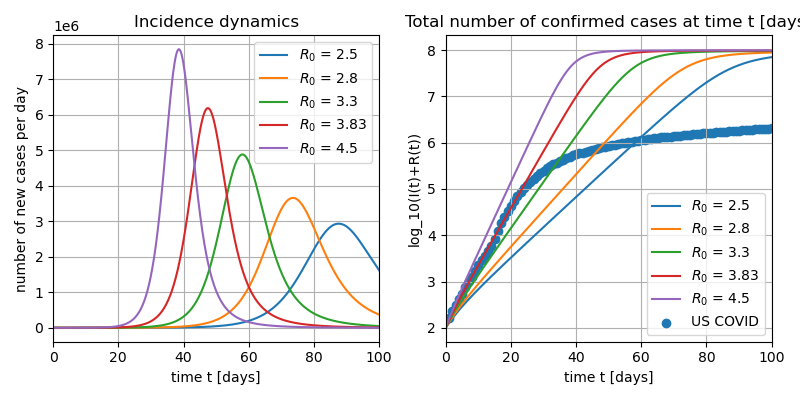

In [6]:
incidence_dynamics(f, N=1e8, T=10, R0range=[2.5, 2.8, 3.3, 3.83, 4.5], yrange=[0, 1], tmax=100)